# Requirements

# Imports

In [59]:
from datasets import load_dataset
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Chargement des données et pré-traitement

In [60]:
df = pd.read_csv('clean.csv')
numeric_df = df.select_dtypes(include=[np.number])

In [61]:
numeric_df.columns

Index(['age', 'days_since_last_login', 'avg_time_spent',
       'avg_transaction_value', 'points_in_wallet', 'churn_risk_score'],
      dtype='object')

In [62]:
df.columns

Index(['age', 'gender', 'security_no', 'region_category',
       'membership_category', 'joining_date', 'joined_through_referral',
       'referral_id', 'preferred_offer_types', 'medium_of_operation',
       'internet_option', 'last_visit_time', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score'],
      dtype='object')

In [63]:
df = df.replace({"F": -1, "M": 1})
df = df.replace({"Unknown": 0})




# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# reading_scores = df["reading_score"].values.reshape(-1, 1)
# writing_scores = df["writing_score"].values.reshape(-1, 1)
# On applique une normalisation MinMax pour que les colonnes aient les mêmes poids.
# df['reading_score'] = scaler.fit_transform(reading_scores)
# df['writing_score'] = scaler.fit_transform(writing_scores)


In [64]:
num_corr = numeric_df.corr()
num_corr['churn_risk_score']

age                      0.006124
days_since_last_login   -0.006228
avg_time_spent          -0.014263
avg_transaction_value   -0.218012
points_in_wallet        -0.307439
churn_risk_score         1.000000
Name: churn_risk_score, dtype: float64

# Matrice de Corrélation

Essayons d'abord de comprendre comment sont corrélés nos attributs d'entrée dans notre dataset.
On note pas de grande redondance entre nos informations, éventuellement au niveau de l'attribut "has completed preparation test"

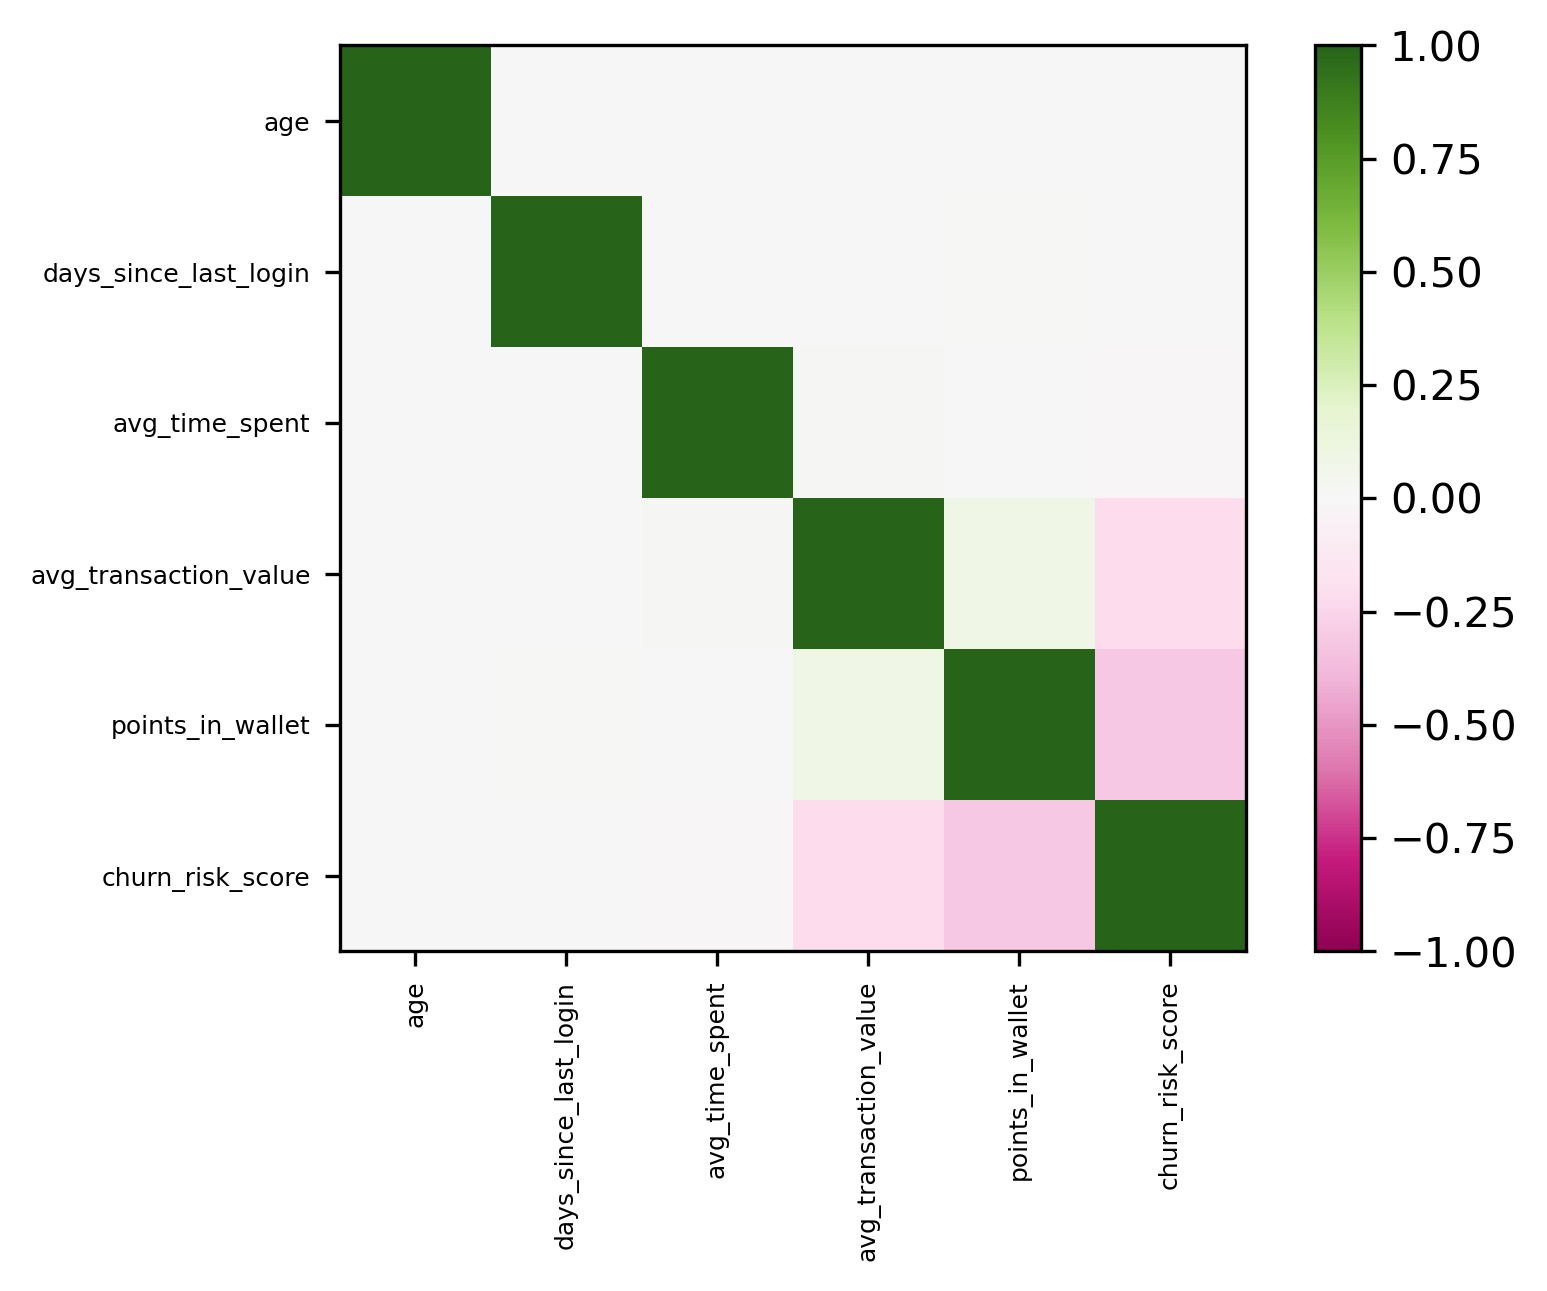

In [65]:
plt.figure(dpi=300)
plt.imshow(num_corr, cmap=plt.get_cmap("PiYG"), vmin=-1, vmax=1) # Pour se convaincre qu'il y a bien de la corrélation
plt.xticks(range(len(numeric_df.columns)), numeric_df.columns, fontsize=6, rotation=90)
plt.yticks(range(len(numeric_df.columns)), numeric_df.columns, fontsize=6)
plt.colorbar()

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

numeric_df_without_na = numeric_df.dropna(inplace=False)
features = numeric_df_without_na.drop('churn_risk_score', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, numeric_df_without_na.churn_risk_score, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.703725782414307
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.57      0.64      3093
           1       0.69      0.82      0.75      3617

    accuracy                           0.70      6710
   macro avg       0.71      0.69      0.69      6710
weighted avg       0.71      0.70      0.70      6710



/home/xennos/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
from lime import lime_tabular

def predict_fn(model):
  def predict_proba(X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        outputs = model(X_tensor).numpy()
        proba = np.hstack((1 - outputs, outputs))
        return proba
  return predict_proba

df = load_transform("math")

X, y = prepare_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = train_logistic_regression(X_train, y_train)

def explain(model, df, index):
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train.numpy(),
        feature_names=df.columns,
        class_names=['Not Passed', 'Passed'],
        mode='classification')

    instance = X_test[index].numpy().reshape(1, -1)
    exp = explainer.explain_instance(instance[0], predict_fn(model), num_features=5)
    exp.show_in_notebook(show_table=True, show_all=False)
explain(model, df, 0)

NameError: name 'load_transform' is not defined